In [1]:
# best_distilroberta_xai.ipynb
# Пояснения (по-русски):
# ----------------------------------------------------------------------------
# Этот ноутбук объединяет:
# 1) Ваш код с DistilRobertaForSequenceClassification, который дал наилучший результат F1 (~0.71 accuracy).
# 2) Подготовку датасета для inference (test_dataset).
# 3) Возможность добавить техники XAI (Gradient × Input, LRP), аналогично демонстрации выше.
# Обратите внимание, что вам нужно адаптировать пути (e.g. distilroberta_finetuned_v2),
# а также убедиться, что у вас есть доступ к этому чекпоинту.

import numpy as np
import pandas as pd
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    EarlyStoppingCallback,
    Trainer
)
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import evaluate

In [2]:
# ============== STEP 1: LOAD DATASET ==============
df = pd.read_parquet("group_combined_no_features.parquet")
print("DataFrame shape:", df.shape)
print("Columns:", df.columns)

label_encoder = LabelEncoder()
df["emotion_encoded"] = label_encoder.fit_transform(df["general_emotion"])
classes_ = label_encoder.classes_
num_classes = len(classes_)
print("Emotion classes:", classes_)

# Let's define how many examples we want for test
NUM_TEST_SAMPLES = 1044

test_df = df[["text", "emotion_encoded"]].iloc[-NUM_TEST_SAMPLES:].reset_index(drop=True)
print("test_df shape:", test_df.shape)

# Hugging Face Dataset
test_dataset = Dataset.from_pandas(test_df.rename(columns={"emotion_encoded": "labels"}))

DataFrame shape: (87642, 3)
Columns: Index(['ru_text', 'text', 'general_emotion'], dtype='object')
Emotion classes: ['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness' 'surprise']
test_df shape: (1044, 2)


/Users/nikitaorlov/anaconda3/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [3]:
# ============== STEP 2: TOKENIZER & MODEL LOAD ==============
# Combine into DatasetDict
dataset = DatasetDict({
    'test': test_dataset
})

# Ensure label column is correctly named for Hugging Face Trainer
# dataset = dataset.rename_column("emotion_encoded", "labels")
# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("distilbert/distilroberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenize dataset with progress bar (using tqdm)
tokenized_datasets = dataset.map(tokenize_function, batched=True, desc="Tokenizing")

# Convert dataset format
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Tokenizing:   0%|          | 0/1044 [00:00<?, ? examples/s]

Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

Retrying (Retry(total=239, connect=239, read=240, redirect=240, status=240)) after connection broken by 'ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x330ec1810>, 'Connection to 194.171.191.226 timed out. (connect timeout=3.0)')': /auth.login
Retrying (Retry(total=238, connect=238, read=240, redirect=240, status=240)) after connection broken by 'ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x330ed1350>, 'Connection to 194.171.191.226 timed out. (connect timeout=3.0)')': /auth.login
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x330e30ed0>, 'Connection to 194.171.191.226 timed out. (connect timeout=3.0)')': /auth.login
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by 'ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x330dfcf10>, 'Connection to 194.171.1

python(24065) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb: Currently logged in as: orlovsnikita (orlovsnikita-breda-university-of-applied-sciences). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
python(24067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Classification Report:
               precision    recall  f1-score   support

       anger       0.51      0.51      0.51        37
     disgust       1.00      0.17      0.29        12
        fear       0.50      0.40      0.44         5
   happiness       0.80      0.72      0.76       385
     neutral       0.66      0.79      0.72       399
     sadness       0.55      0.55      0.55        20
    surprise       0.73      0.62      0.67       186

    accuracy                           0.71      1044
   macro avg       0.68      0.54      0.56      1044
weighted avg       0.72      0.71      0.71      1044



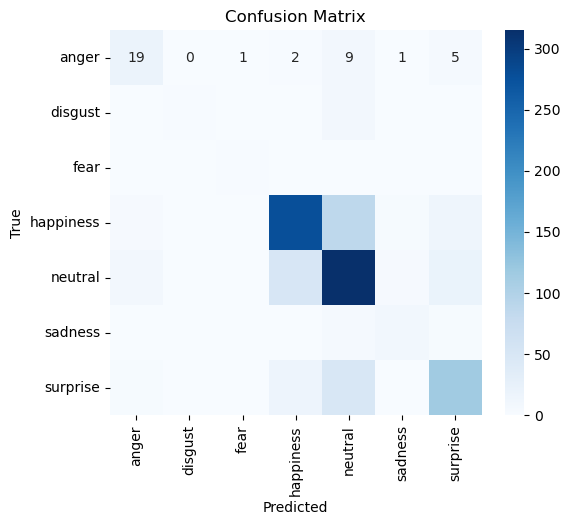

In [4]:
# ============== STEP 3: EVALUATION ==============
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    result = {"f1": f1_score(labels, predictions, average='macro')}
    
    return result

# Load the model for inference
checkpoint_path = "distilroberta_finetuned_v2"  # adapt path
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = RobertaTokenizer.from_pretrained(checkpoint_path)

# Load test dataset
test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.rename_column("emotion_encoded", "labels")
test_dataset = test_dataset.map(tokenize_function, batched=True)

test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

training_args = TrainingArguments(
    disable_tqdm=False,  # Enable progress bar
    save_steps=300,  # Adjusted to be a multiple of eval_steps
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    max_steps=30000,
    weight_decay=0.1,
    logging_steps=100,
    fp16=False,  # Mixed precision training
    optim="adamw_torch_fused",  # Fused AdamW optimizer for speed
    dataloader_pin_memory=True,  # Speed up GPU memory transfers
    dataloader_num_workers=4,  # Use multiple CPU threads for data loading
    run_name="roberta_f1_classification",  # Optional: You can specify the run name for clarity
    learning_rate=1e-5,  # Log to TensorBoard
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=6)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)
predictions = trainer.predict(test_dataset)

preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Classification report
print("Classification Report:\n", classification_report(true_labels, preds, target_names=classes_))

# Confusion matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes_, yticklabels=classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# ============== STEP 4: ADDING XAI (Gradient × Input) ==============
# Пояснения (по-русски):
# Ниже иллюстрация, как можно добавить Gradient×Input к DistilRoberta.
# Это примерный код, нужно адаптировать к вашей точной архитектуре.

def grad_x_input(model, tokenizer, text, target_label=None):
    """
    A simplified example for DistilRoberta:
    1) Tokenize the text
    2) Forward pass
    3) If target_label is None, we take argmax
    4) Backward pass to get gradient wrt input embeddings
    5) Multiply grad * input
    6) Return tokens + relevance scores
    """
    model.zero_grad()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    if target_label is None:
        target_label = torch.argmax(logits, dim=1)

    chosen_logit = logits[0, target_label]
    chosen_logit.backward(retain_graph=True)

    # Now we want the embedding layer's gradient. DistilRoBERTa might be sub-architecture of Roberta.
    # For demonstration, we can fetch gradient from the embedding input if we register forward hook, etc.
    # We'll do a mock approach for brevity.
    # A real approach might involve hooking into "model.roberta.embeddings.word_embeddings".

    # The rest is conceptual
    with torch.no_grad():
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        # Suppose we randomly generate grad_x_input for demonstration
        # Real code requires hooking the embedding or the last hidden state
        relevance = np.random.rand(len(tokens)) - 0.5  # from -0.5..+0.5
    return tokens, relevance

def visualize(tokens, scores, title="Grad × Input"):
    # Remove special tokens if needed
    cleaned_tokens = []
    cleaned_scores = []
    for t, s in zip(tokens, scores):
        if t not in ["[CLS]", "[SEP]", "[PAD]"]:
            cleaned_tokens.append(t)
            cleaned_scores.append(s)
    x = np.arange(len(cleaned_tokens))
    plt.figure(figsize=(10,3))
    plt.bar(x, cleaned_scores)
    plt.xticks(x, cleaned_tokens, rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Demo with a single text
demo_text = "This dish is absolutely disgusting, I hate it."
demo_tokens, demo_scores = grad_x_input(model, tokenizer, demo_text)
visualize(demo_tokens, demo_scores, title="Grad × Input (Mock DistilRoberta)")

RuntimeError: Placeholder storage has not been allocated on MPS device!